# SDXL txt2img and img2img Inference

This notebook demonstrates text-to-image (txt2img) and image-to-image (img2img) inference using the project's SDXL engine (`ml.src.diffusion.engine.SDXLEngine`).

In [1]:
import sys, os
from pathlib import Path
from datetime import datetime
import torch
from PIL import Image
from ml.src.diffusion.engine import SDXLEngine

from IPython.display import display

def show(img: Image.Image, title: str | None = None):
    display(img)

def save(img: Image.Image, name: str) -> Path:
    path = out_dir / name
    img.save(path)
    return path

def side_by_side(left: Image.Image, right: Image.Image) -> Image.Image:
    w = left.width + right.width
    h = max(left.height, right.height)
    canvas = Image.new('RGB', (w, h))
    canvas.paste(left, (0, 0))
    canvas.paste(right, (left.width, 0))
    return canvas

def make_contact_sheet(images, cols=4, max_thumb=256):
    if len(images) == 0:
        return None
    thumbs = []
    for img in images:
        ratio = min(max_thumb / img.width, max_thumb / img.height, 1.0)
        w = int(img.width * ratio)
        h = int(img.height * ratio)
        thumbs.append(img.copy().resize((w, h)))
    rows = (len(thumbs) + cols - 1) // cols
    cell_w = max(t.width for t in thumbs)
    cell_h = max(t.height for t in thumbs)
    sheet = Image.new("RGB", (cell_w * cols, cell_h * rows), color=(0, 0, 0))
    for idx, t in enumerate(thumbs):
        r = idx // cols
        c = idx % cols
        sheet.paste(t, (c * cell_w, r * cell_h))
    return sheet


/root/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Locate repository root (contains 'ml/src')
repo_root = Path.cwd()
if not (repo_root / 'ml' / 'src').exists():
    cand = repo_root
    for _ in range(6):
        if (cand / 'ml' / 'src').exists():
            repo_root = cand
            break
        cand = cand.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print('Repo root:', repo_root)

# Ensure PYTHONPATH includes repo_root
existing = os.environ.get('PYTHONPATH', '')
if str(repo_root) not in existing.split(os.pathsep):
    os.environ['PYTHONPATH'] = str(repo_root) + (os.pathsep + existing if existing else '')

# Ensure outputs directory exists
timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
out_dir = repo_root / 'ml' / 'notebooks' / 'ml' / 'outputs' / f'notebook-{timestamp}'
out_dir.mkdir(parents=True, exist_ok=True)
print('Output dir:', out_dir)


Repo root: /root/lcc-aldar-kose
Output dir: /root/lcc-aldar-kose/ml/notebooks/ml/outputs/notebook-20251019-040700


## Configuration
- Adjust the prompt and parameters below.
- Width/height should typically be multiples of 8 (SDXL commonly uses 1024x1024).
- Seed controls reproducibility.


In [3]:
BASE_ID = 'stabilityai/stable-diffusion-xl-base-1.0'
WIDTH = 1024
HEIGHT = 1024
STEPS = 30
GUIDANCE = 7.5
SEED = 12345
NEGATIVE_PROMPT = 'low detail, extra fingers, distorted faces, stereotype imagery'

PROMPT = 'Given photo of Aldar. Replicate this Photo. • Middle-aged Kazakh trickster • traditional chapan robe • kalpak hat • gentle, knowing smile • rooted in Kazakh green steppe heritage, folk textiles, and oral storytelling traditions'
IMG2IMG_STRENGTH = 0.95  # 0.0 = copy init, 1.0 = ignore init


## Initialize Engine
This loads the SDXL txt2img and img2img pipelines and applies memory optimizations automatically (VAE tiling/slicing, xFormers if available).


In [4]:
engine = SDXLEngine({
    'base_id': BASE_ID,
    'width': WIDTH,
    'height': HEIGHT,
    'steps': STEPS,
    'guidance': GUIDANCE,
    'negative_prompt': NEGATIVE_PROMPT,
})

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Engine ready on', device, '| dtype:', engine.get_dtype())


Loading pipeline components...: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Deprecation warning: passing multiple tokenizers/text encoders to Compel is deprecated and will be removed in v3.0. Use one of the CompelFor* classes in multi_model_wrappers instead
Engine ready on cuda | dtype: torch.float16


## txt2img
Generate an image from the text prompt.


In [5]:
txt2img = engine.generate(
        prompt=PROMPT,
        width=WIDTH,
        height=HEIGHT,
        steps=STEPS,
        guidance=GUIDANCE,
    )

images = []
prev = None

for i in range(8):
    seed_i = 4242 + i
    img = engine.generate(
        prompt=PROMPT,
        seed=seed_i,
        width=WIDTH,
        height=HEIGHT,
        steps=STEPS,
        guidance=GUIDANCE,
    )
    images.append(img)
    prev = img
    save(img, f"frame_{i:02d}.png")


100%|██████████| 30/30 [00:01<00:00, 16.70it/s]


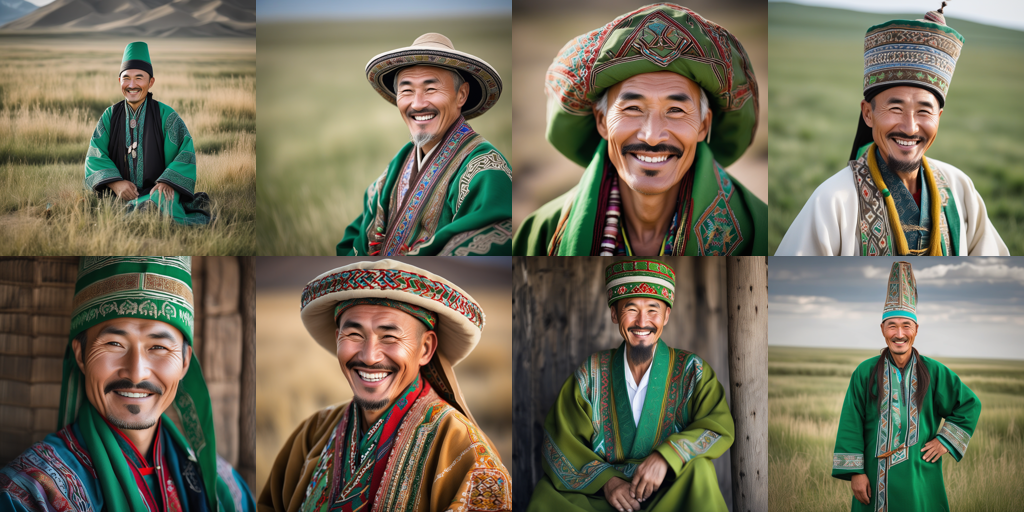

In [6]:
sheet = make_contact_sheet(images, cols=4, max_thumb=256)
if sheet is not None:
    show(sheet, "Contact sheet of frames")
    save(sheet, "frames_contact_sheet.png")

## Multi-frame sequence (txt2img + iterative img2img)

This section generates a longer sequence of frames to demonstrate consistency over time.
- Frame 0 is generated with txt2img.
- Frames 1..N use img2img with the previous frame as the init image.
- Set `FRAME_SEED_MODE` to `fixed` to keep the seed the same across frames, or `increment` to vary it per frame.


In [7]:
N_FRAMES = 8
FRAME_SEED_MODE = "increment"  # "fixed" or "increment"
SEED_BASE = 4242
STRENGTH = 0.95  # alias for per-sequence tweaking


In [8]:
img2img_from_prev = engine.generate(
    prompt=PROMPT,
    seed=SEED,
    img2img_start=txt2img,
    strength=IMG2IMG_STRENGTH,
    width=WIDTH,
    height=HEIGHT,
    steps=STEPS,
    guidance=GUIDANCE,
)

100%|██████████| 28/28 [00:01<00:00, 16.77it/s]


In [9]:
prev = None
images = []
for i in range(N_FRAMES):
    seed_i = SEED_BASE if FRAME_SEED_MODE == "fixed" else (SEED_BASE + i)
    img = engine.generate(
        prompt=PROMPT,
        seed=seed_i,
        img2img_start=prev,       # recurrence
        strength=STRENGTH,        # controls deviation from prev frame
        width=WIDTH,
        height=HEIGHT,
        steps=STEPS,
        guidance=GUIDANCE,
    )
    images.append(img)
    prev = img                   # feed forward previous result
    save(img, f"frame_{i:02d}.png")


100%|██████████| 28/28 [00:01<00:00, 14.89it/s]


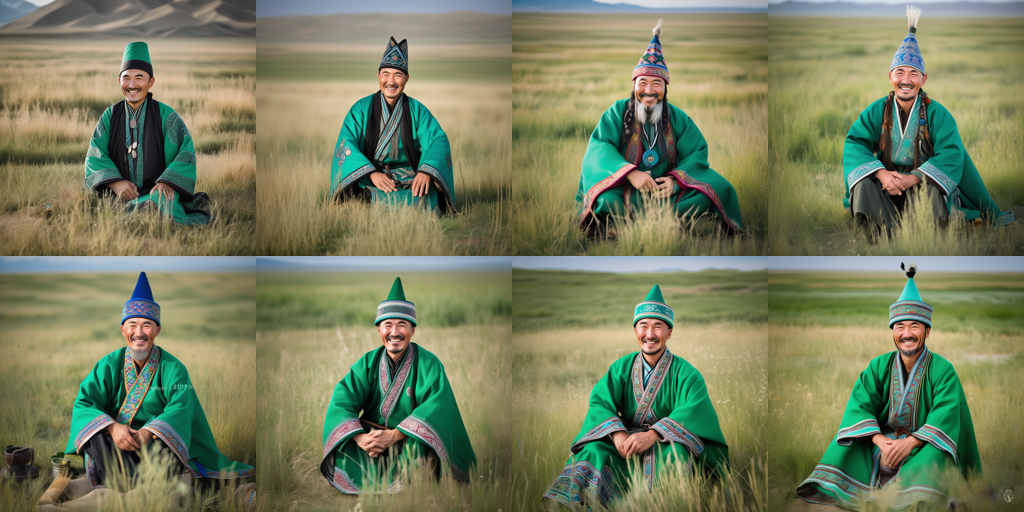

In [10]:
sheet = make_contact_sheet(images, cols=4, max_thumb=256)
sheet